In [24]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# 定义时间步长
time_steps = 10
scaler = MinMaxScaler()

In [25]:
#数据预处理
def pre_process_dataset(input_data):
  data=input_data.loc[:,['Date', 'Count']]
  data=data.dropna()
  data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y %I:%M:%S %p')
  data['Day'] = data['Date'].dt.strftime('%Y-%m-%d')
  #按照天进行聚合
  data = data.groupby('Day').sum()
  return data

In [26]:
#读取训练数据
def read_train_data():
  train_data = []
  for year in np.arange(2017,2022,1):
      df_year = pd.read_csv("https://raw.githubusercontent.com/COMP5152TEAMWORK/Chicago-Crimes-Analysis/main/data/" + str(year) + ".csv")
      train_data.append(df_year)
  train_data = pd.concat(train_data, ignore_index=True)
  train_data['Count']=1
  return train_data

In [27]:
#读取测试数据
def read_test_data():
  test_data = pd.read_csv("https://raw.githubusercontent.com/COMP5152TEAMWORK/Chicago-Crimes-Analysis/main/data/2022.csv")
  test_data['Count']=1
  return test_data

In [28]:
from sklearn.preprocessing import MinMaxScaler
# 对数据进行归一化处理
def normalize_data(train_data, test_data):
  train_data_norm = scaler.fit_transform(train_data)
  test_data_norm = scaler.transform(test_data)
  return train_data_norm, test_data_norm

In [29]:
# 定义函数将数据转换为适合LSTM模型的格式
def create_dataset(data, window_size):
  X, y = [], []
  for i in range(len(data) - window_size):
      X.append(np.reshape(data[i:(i+window_size)], (window_size, 1)))
      y.append(data[i+window_size])
  return np.array(X), np.array(y)

In [30]:
#将训练集和测试集转换为适合LSTM模型的格式
def transform_dataset_for_LSTM(train_data_norm, test_data_norm, time_steps):
  X_train, y_train = create_dataset(train_data_norm, time_steps)
  X_test, y_test = create_dataset(test_data_norm, time_steps)
  return X_train, y_train, X_test, y_test

In [31]:
from tensorflow import keras
from keras.layers import LSTM, Dense
from keras.layers import Dropout

def train_model(X_train, y_train, window_size):
  model = keras.Sequential()
  model.add(LSTM(5, input_shape=(window_size, 1)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
  return model
# model = keras.Sequential()
# # Adding the first LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# # Adding a second LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# # Adding a third LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# # Adding a fourth LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

# # Adding the output layer
# model.add(Dense(units = 1))

In [32]:
# 预测数据
def predict(model, X_test):
  y_pred = model.predict(X_test)
  return y_pred

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#获取LSTM的衡量指标，来评估模型的性能
def get_metric(true_labels, predictions):
  # 计算RMSE和MAE
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)
  print("rmse:", rmse)
  print("mae", mae)
  return rmse, mae

In [34]:
#对数据进行反归一化  一般是真实测试标签和预测标签，为了下面画图用
def unnormalize(norm_data):
  return scaler.inverse_transform(norm_data)

In [35]:
import matplotlib.pyplot as plt
def plot_compare(true_labels, predictions, text):

  # 创建一个新的图形对象，设置宽度为10英寸，高度为6英寸
  plt.figure(figsize=(15, 10))

  plt.plot(true_labels, label="True")
  plt.plot(predictions, label="Prediction")

  # 设置图形标题、坐标轴标签、坐标轴刻度和图例
  plt.title("2022 " + text + " Crime")
  plt.xlabel("Time (days)")
  plt.ylabel("Number of " + text + " Crimes")
  plt.xticks(range(0, len(true_labels), 30))
  plt.legend()

  # 显示图形
  plt.savefig("2022 " + text + " Crime.jpg")
  plt.show()


In [36]:
def predict_2023_crime(model, y_test):
  # 创建一个空的数组来存储预测结果
  predicted_data = np.zeros((365, 1))

  # 使用2022年最后两个月作为第一个输入
  input_data = y_test[-time_steps:]

  #循环预测23年的犯罪趋势
  for i in range(365):

      predicted_normalized = model.predict(input_data.reshape(1, time_steps, 1), verbose=0)
      
      # 将预测结果进行反归一化处理
      predicted = scaler.inverse_transform(predicted_normalized.reshape(-1, 1))

      # 将预测结果添加到预测数组中
      predicted_data = np.append(predicted_data, predicted, axis=0)

      # 将预测结果添加到输入数据中，用于下一次预测
      input_data = np.vstack((input_data[1:], predicted_normalized))

  #删除预测数组中的前12个零值
  predicted_data = predicted_data[365:]
  #print(len(predicted_data))
  return predicted_data

In [37]:
def count_days(year):
  # 判断是否为闰年
  if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
      days = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
  else:
      days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
  return days

In [38]:
def plot_2023_crime(predicted_data, text):
  days_in_month = count_days(2023)
  # 将crime_data转化为月数据
  crime_data_monthly = []
  start_day = 0  # 每个月的起始天数
  for days in days_in_month:
    monthly_data = sum(predicted_data[start_day:start_day+days])
    crime_data_monthly.append(monthly_data)
    start_day += days
  print(crime_data_monthly)
  # 将月数据绘制成折线图
  x = range(1, 13, 1)
  plt.figure(figsize=(15, 10))
  x_ticks = ["2023-"+str(i) for i in range(1, 13)]
  plt.xticks(x, x_ticks)

  plt.plot(x, crime_data_monthly)
  plt.title(text + ' Crime')
  plt.xlabel('Month')
  plt.ylabel('Number of ' + text + ' Crimes')
  plt.savefig('2023 ' + text + ' Crime.jpg')
  plt.show()

11/11 [==============================] - 1s 3ms/step
rmse: 0.024640670496487653
mae 0.018455538851054006


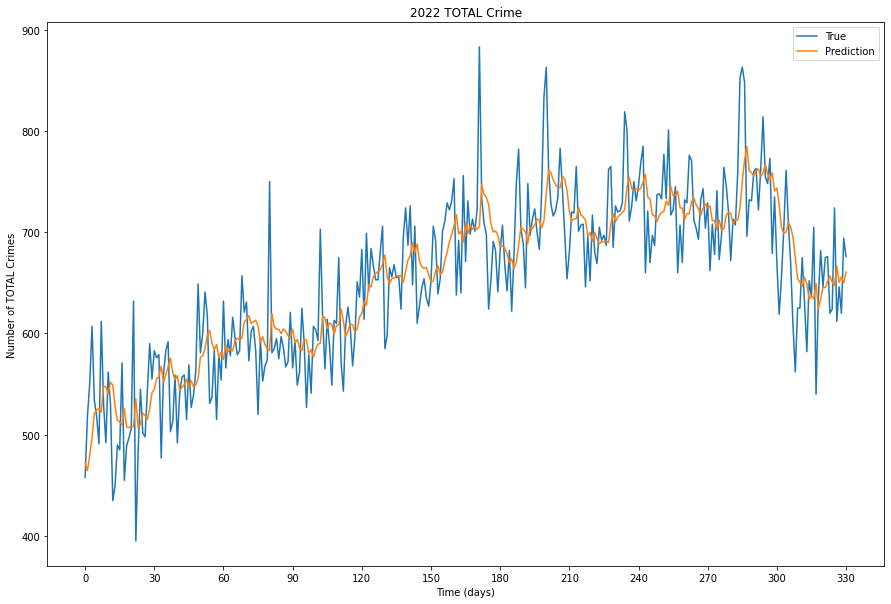

[array([20919.92132568]), array([19413.52246094]), array([21867.18414307]), array([21404.2052002]), array([22275.2845459]), array([21652.21124268]), array([22434.99291992]), array([22473.23687744]), array([21770.64611816]), array([22510.49255371]), array([21792.78936768]), array([22524.5614624])]


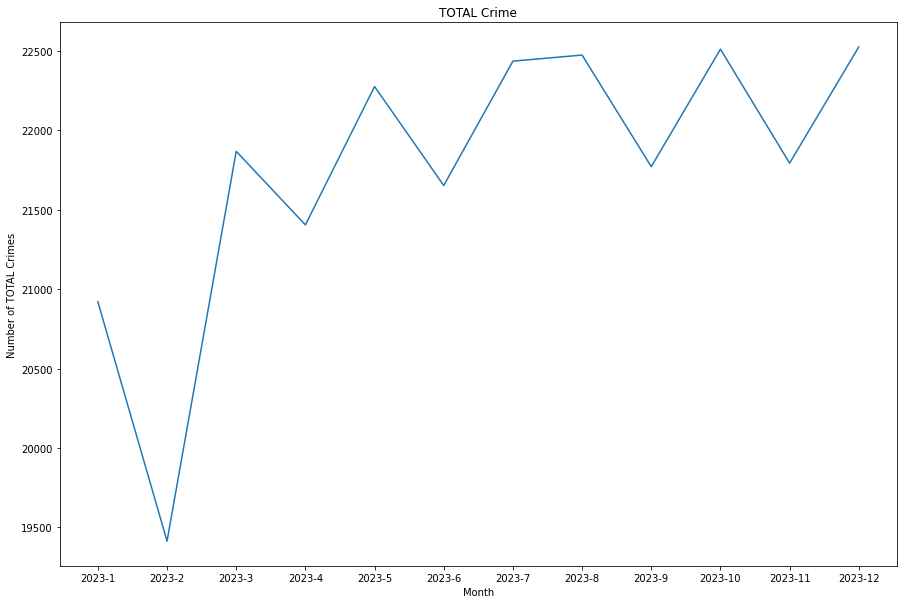

In [39]:
#第一种，预测2023年总体犯罪的趋势
#1.读取训练数据17年到21年
train_data = read_train_data()
#2.读取测试数据22年
test_data = read_test_data()
#3.生成预处理后的训练集和测试集
train_data = pre_process_dataset(train_data)
test_data = pre_process_dataset(test_data)
#4.对数据进行归一化处理
train_data_norm, test_data_norm = normalize_data(train_data, test_data)
#5.将数据转换成LSTM模型的输入格式
X_train, y_train, X_test, y_test = transform_dataset_for_LSTM(train_data_norm, test_data_norm, time_steps)
#6.训练模型
model = train_model(X_train, y_train, time_steps)
#7.用训练好的模型对测试集预测
y_pred = predict(model, X_test)
#8获取LSTM的衡量指标，来评估模型的性能
get_metric(y_test, y_pred)
#9对数据进行反归一化  画图用
true_labels = unnormalize(y_test)
predictions = unnormalize(y_pred)
#10.画出22年真实和预测数据的对比图
plot_compare(true_labels, predictions, "TOTAL")
#11.用22年的最后10天数据预测23年的第一天数据，以此类推
predicted_data = predict_2023_crime(model, y_test)
#12.画出23年的预测图
plot_2023_crime(predicted_data, "TOTAL")

In [40]:
#根据对原始数据的分析，选择几个维度去预测趋势，比如col = 'Primary type'
def get_top_five_value(train_data, col):
  col_count = train_data.groupby(col, as_index=False).sum()
  col_count = col_count.sort_values('Count',ascending=False)
  top_five = set(col_count.head(5)[col])
  return top_five

In [41]:
original_train_data = read_train_data()
original_test_data = read_test_data()
primary_type_data = get_top_five_value(original_train_data, 'Primary Type')
location_description_data = get_top_five_value(original_train_data, 'Location Description')
#print(location_description_data)

11/11 [==============================] - 1s 3ms/step
rmse: 0.07587295509487355
mae 0.06215479005555183


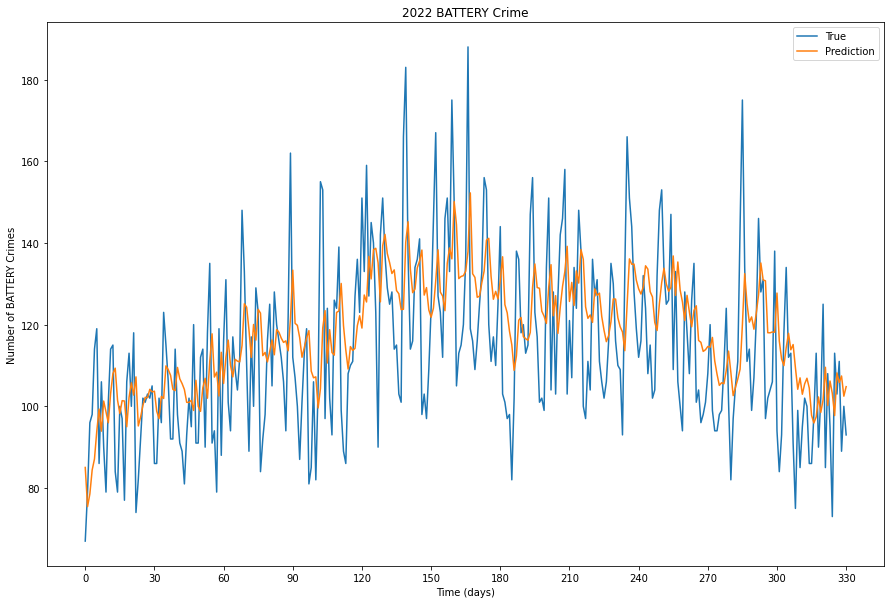

[array([3652.58333588]), array([3892.11056519]), array([4463.08731079]), array([4339.6030426]), array([4486.49409485]), array([4342.00027466]), array([4486.75854492]), array([4486.75994873]), array([4342.02575684]), array([4486.75994873]), array([4342.02575684]), array([4486.75994873])]


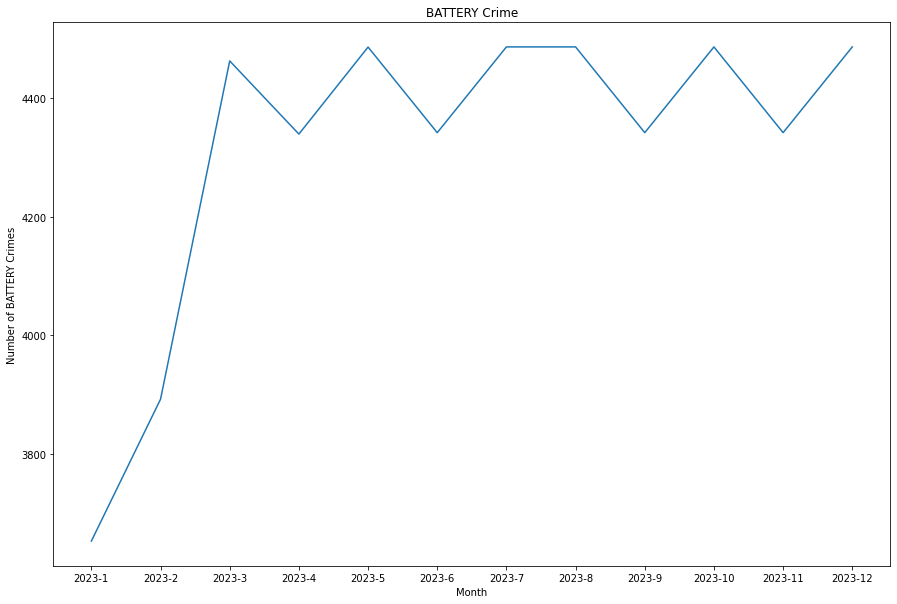

11/11 [==============================] - 1s 3ms/step
rmse: 0.09637165658153209
mae 0.07779945499030681


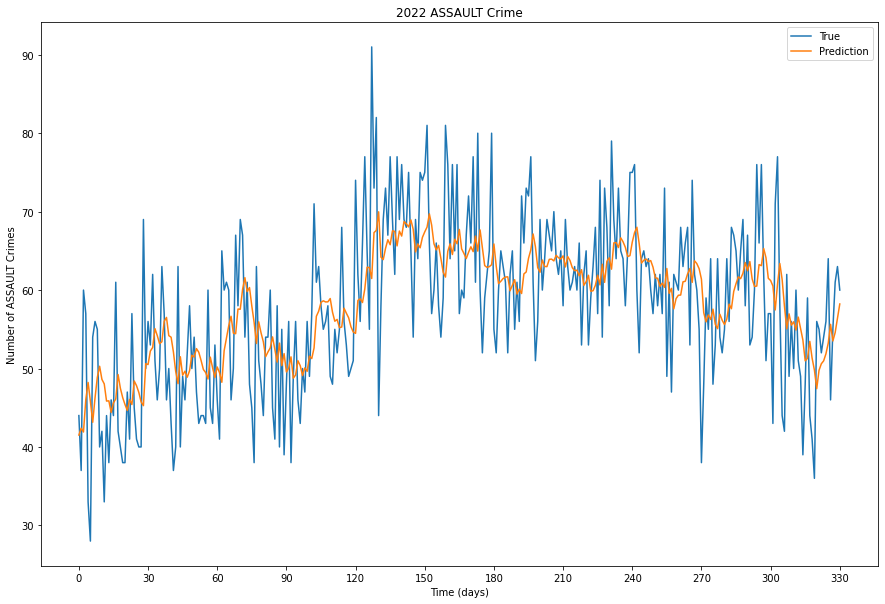

[array([1864.0716095]), array([1712.00680161]), array([1901.18249512]), array([1840.97141266]), array([1902.54415894]), array([1841.20825195]), array([1902.58863831]), array([1902.58995819]), array([1841.21612549]), array([1902.58999634]), array([1841.21612549]), array([1902.58999634])]


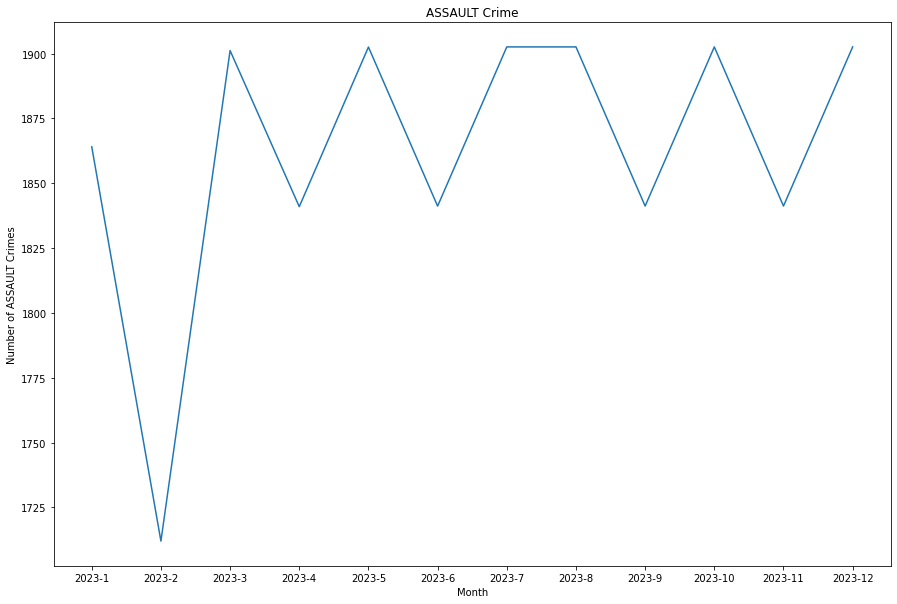

11/11 [==============================] - 1s 4ms/step
rmse: 0.07082239958281607
mae 0.05253702709267183


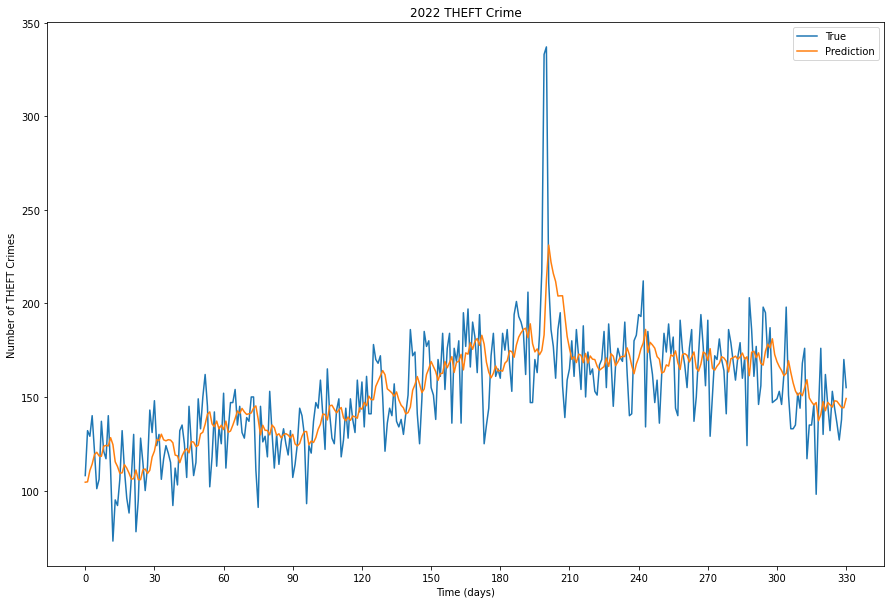

[array([4992.32003784]), array([5015.30667114]), array([5930.34017944]), array([5953.92375183]), array([6260.90940857]), array([6106.9836731]), array([6332.24923706]), array([6341.75204468]), array([6141.03507996]), array([6347.43196106]), array([6143.38014221]), array([6348.46820068])]


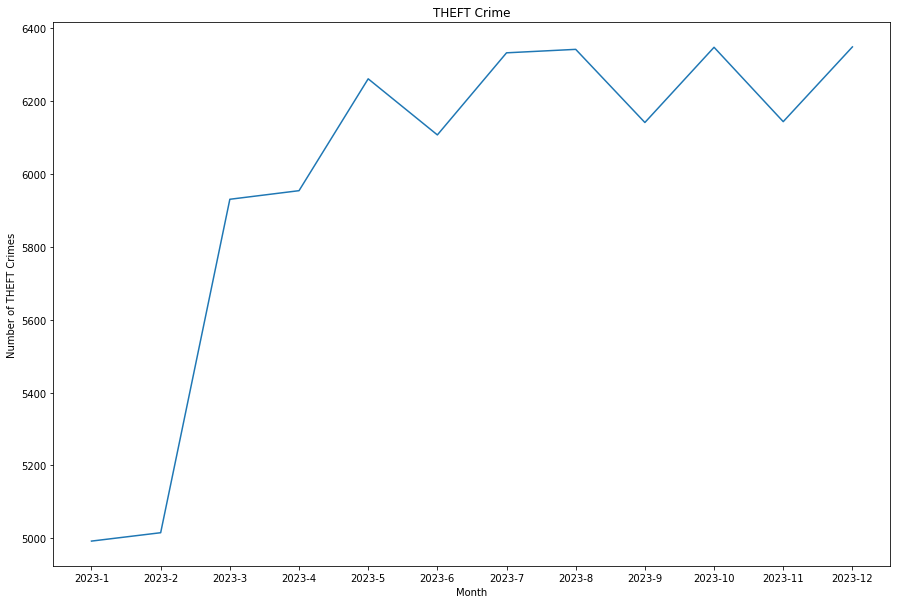

11/11 [==============================] - 1s 3ms/step
rmse: 0.0342438037124073
mae 0.028006543238421024


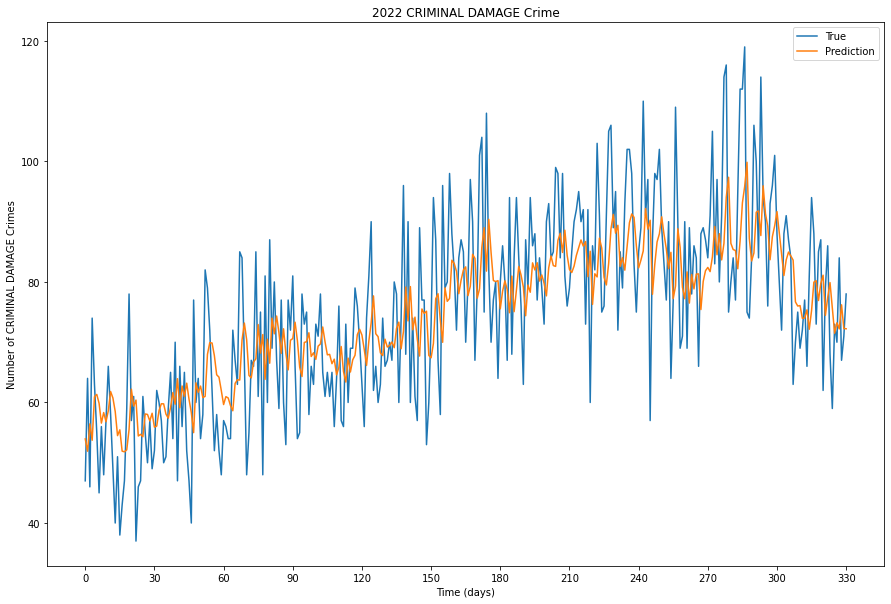

[array([2300.01693726]), array([2084.56732178]), array([2309.09151459]), array([2234.79227448]), array([2309.31355286]), array([2234.8239212]), array([2309.31816864]), array([2309.31816864]), array([2234.82403564]), array([2309.31816864]), array([2234.82403564]), array([2309.31816864])]


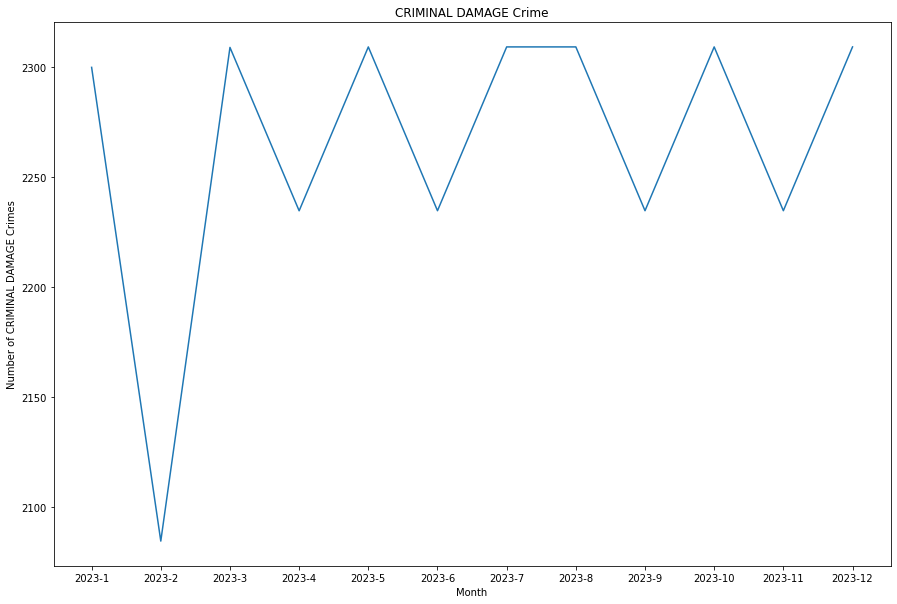

11/11 [==============================] - 1s 6ms/step
rmse: 0.06341132422495382
mae 0.04847456274307334


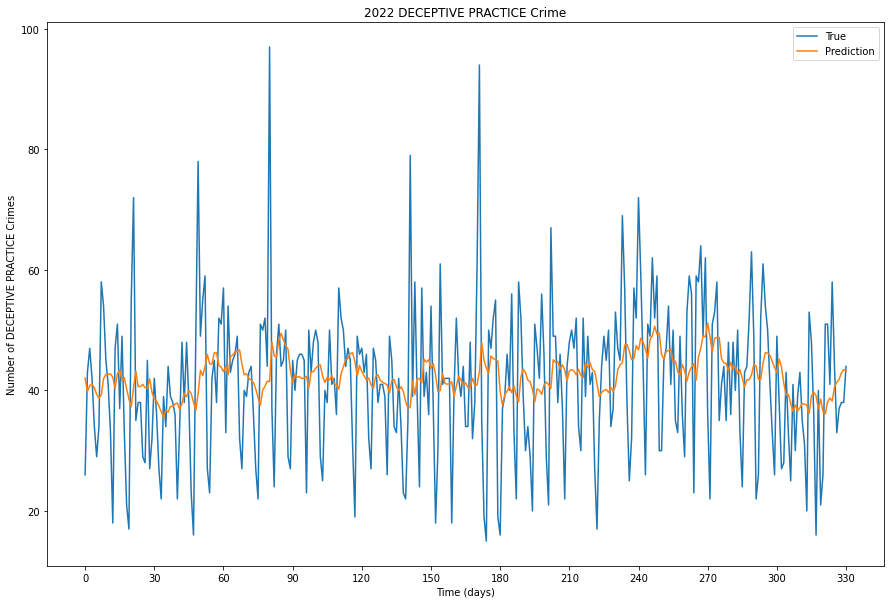

[array([1346.71089935]), array([1254.39413452]), array([1395.58675766]), array([1351.68655014]), array([1396.91753769]), array([1351.88190842]), array([1396.94894028]), array([1396.94956207]), array([1351.88667297]), array([1396.94956207]), array([1351.88667297]), array([1396.94956207])]


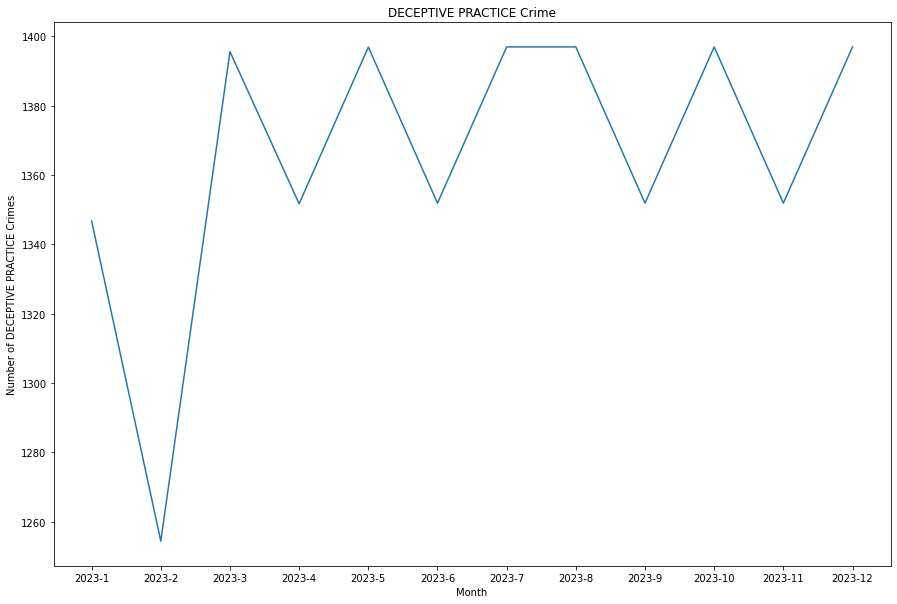

In [42]:
#第一种，预测17-21年犯罪类型排名前五的犯罪，在2023年的趋势
for t in primary_type_data:
  #1.过滤得到某种犯罪类型的数据
  train_data = original_train_data[original_train_data["Primary Type"] == t]
  test_data = original_test_data[original_test_data["Primary Type"] == t]
  #3.生成预处理后的训练集和测试集
  train_data = pre_process_dataset(train_data)
  test_data = pre_process_dataset(test_data)
  #4.对数据进行归一化处理
  train_data_norm, test_data_norm = normalize_data(train_data, test_data)
  #5.将数据转换成LSTM模型的输入格式
  X_train, y_train, X_test, y_test = transform_dataset_for_LSTM(train_data_norm, test_data_norm, time_steps)
  #6.训练模型
  model = train_model(X_train, y_train, time_steps)
  #7.用训练好的模型对测试集预测
  y_pred = predict(model, X_test)
  #8获取LSTM的衡量指标，来评估模型的性能
  get_metric(y_test, y_pred)
  #9对数据进行反归一化  画图用
  true_labels = unnormalize(y_test)
  predictions = unnormalize(y_pred)
  #10.画出22年真实和预测数据的对比图
  plot_compare(true_labels, predictions, t)
  #11.用22年的最后10天数据预测23年的第一天数据，以此类推
  predicted_data = predict_2023_crime(model, y_test)
  #12.画出23年的预测图
  plot_2023_crime(predicted_data, t)

11/11 [==============================] - 1s 3ms/step
rmse: 0.026459446044264704
mae 0.021078797540714376


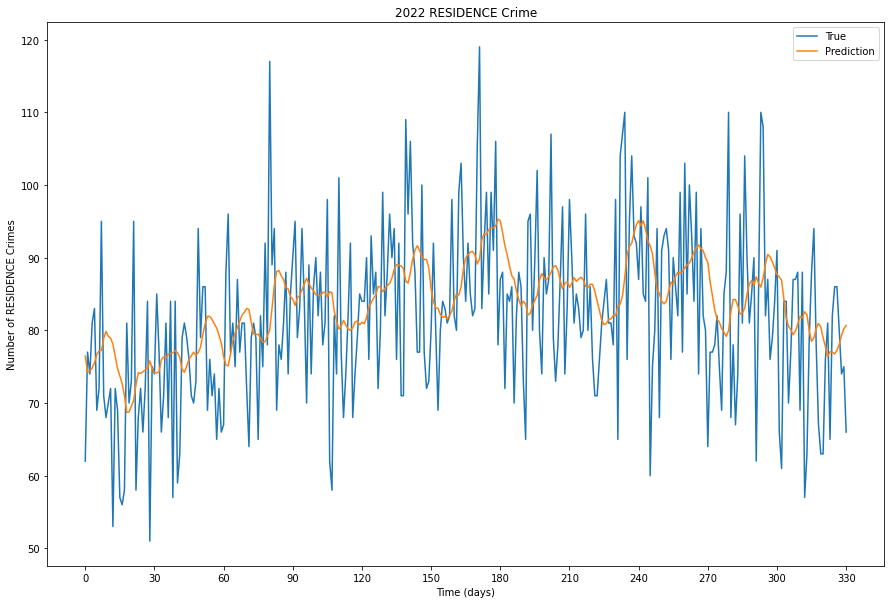

[array([2597.81719208]), array([2524.22051239]), array([2875.80247498]), array([2816.98155975]), array([2925.19689178]), array([2836.57174683]), array([2933.5574646]), array([2934.57615662]), array([2840.31025696]), array([2935.15611267]), array([2840.54168701]), array([2935.25508881])]


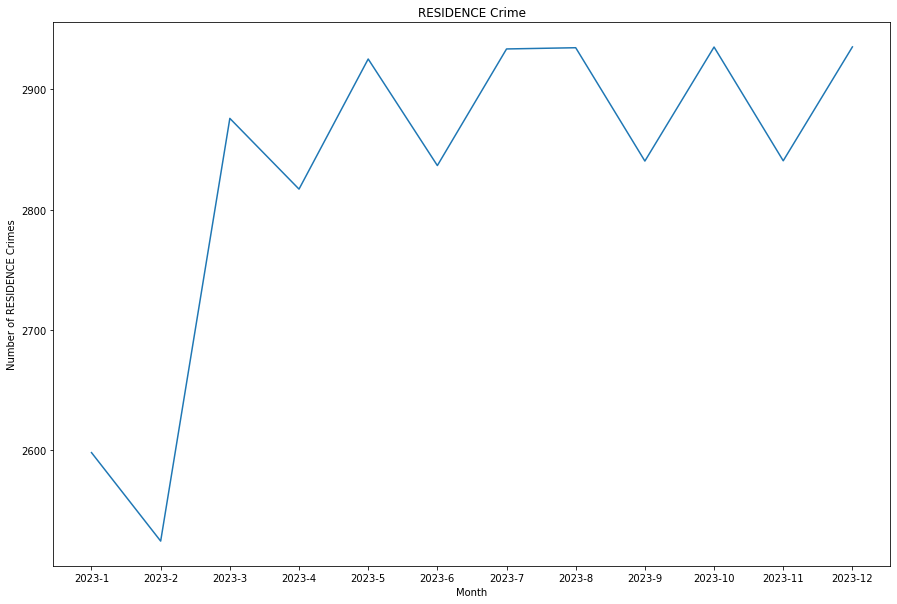

11/11 [==============================] - 1s 4ms/step
rmse: 0.06436256251451523
mae 0.04720069761620165


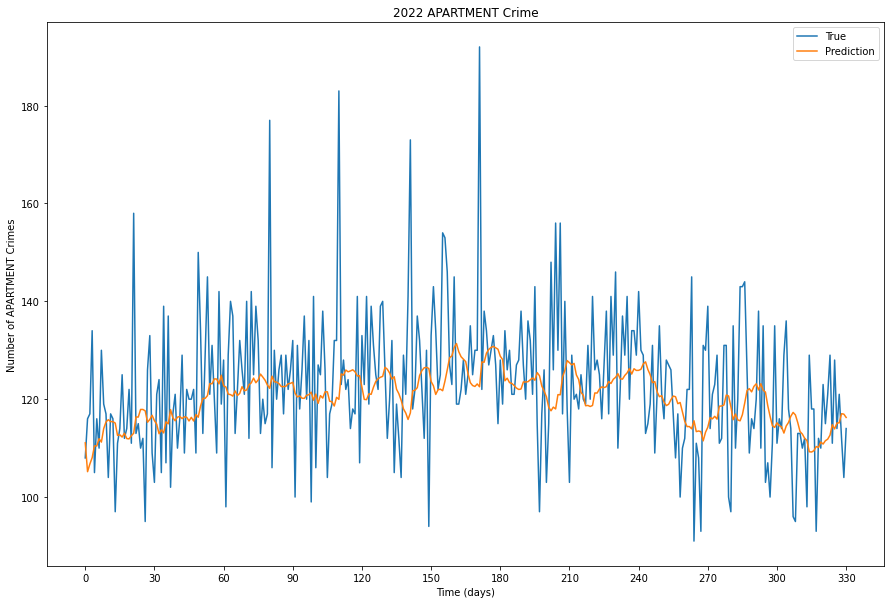

[array([3469.17077637]), array([3063.00592804]), array([3360.66452789]), array([3239.19069672]), array([3341.52189636]), array([3231.41712189]), array([3338.12586212]), array([3337.69477844]), array([3229.85488892]), array([3337.44200134]), array([3229.75167847]), array([3337.39777374])]


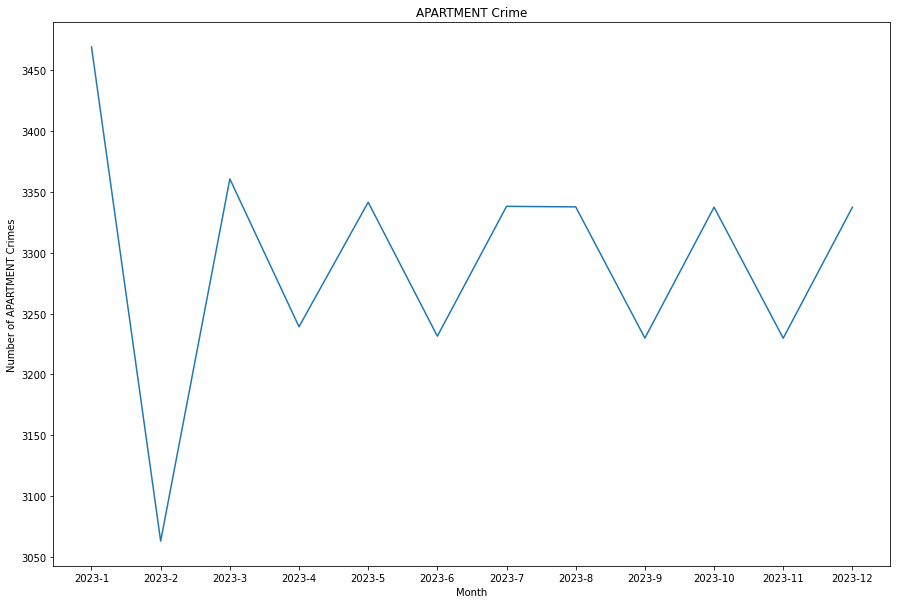

11/11 [==============================] - 1s 3ms/step
rmse: 0.07067599313540832
mae 0.054079950617657906


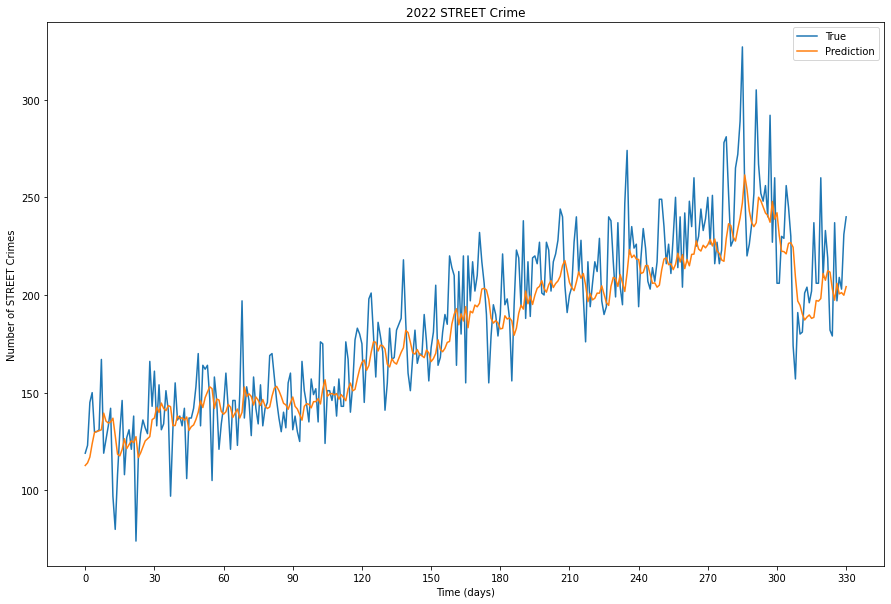

[array([5772.71565247]), array([4434.21351624]), array([4572.79232788]), array([4296.3830719]), array([4391.47262573]), array([4232.93484497]), array([4367.80744934]), array([4365.54402161]), array([4223.9539032]), array([4364.47013855]), array([4223.58250427]), array([4364.33261108])]


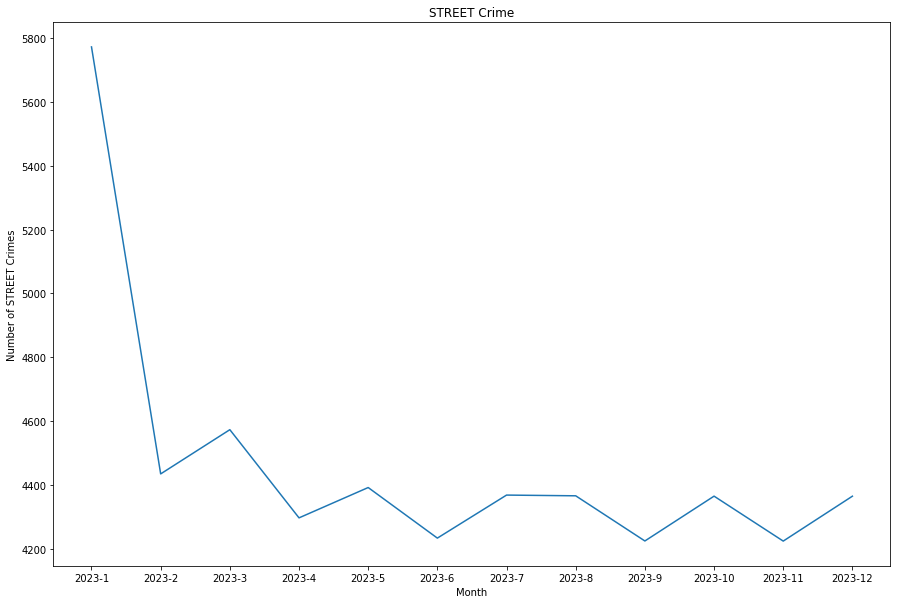

11/11 [==============================] - 1s 5ms/step
rmse: 0.07013796838918095
mae 0.055025175667273996


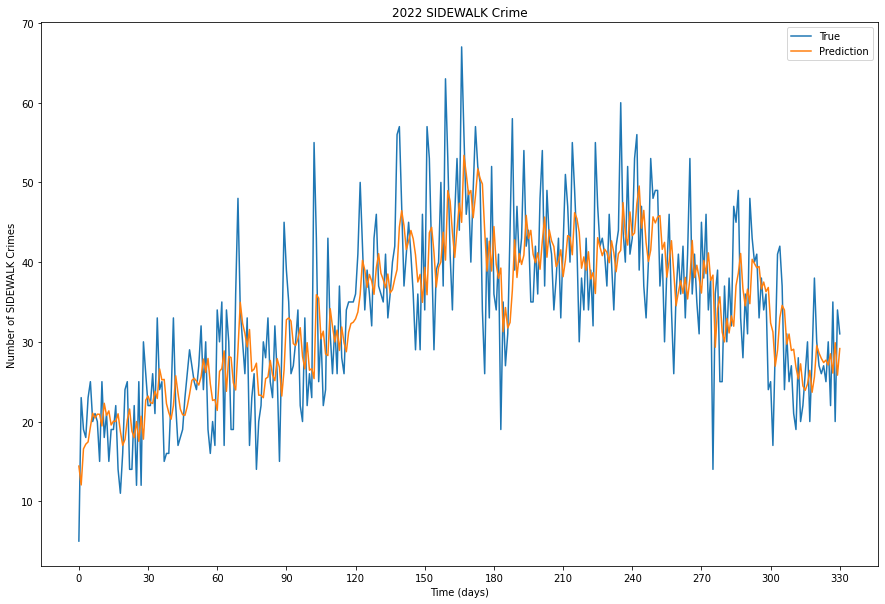

[array([905.01498222]), array([824.57514]), array([917.01068306]), array([889.80067253]), array([920.8584919]), array([891.93190956]), array([922.12384987]), array([922.39286423]), array([892.78495598]), array([922.6313324]), array([892.91763496]), array([922.71046638])]


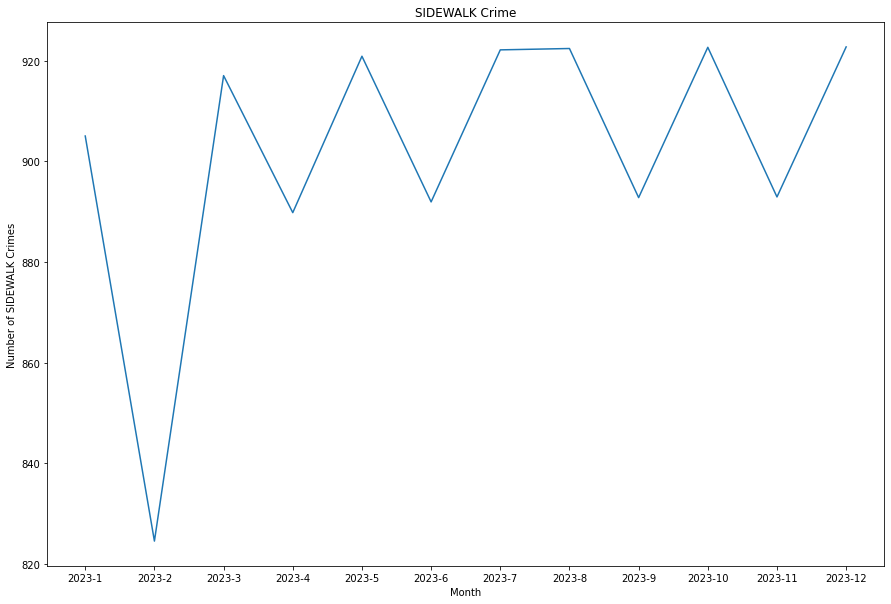

In [43]:
#第二种，预测17-21年犯罪发生地点排名前五的犯罪，在2023年的趋势
for location in location_description_data:
  #1.过滤得到某种犯罪类型的数据
  train_data = original_train_data[original_train_data["Location Description"] == location]
  test_data = original_test_data[original_test_data["Location Description"] == location]
  #3.生成预处理后的训练集和测试集
  train_data = pre_process_dataset(train_data)
  test_data = pre_process_dataset(test_data)
  if len(train_data)==0 or len(test_data) == 0:
    continue
  else:
    #4.对数据进行归一化处理
    train_data_norm, test_data_norm = normalize_data(train_data, test_data)
    #5.将数据转换成LSTM模型的输入格式
    X_train, y_train, X_test, y_test = transform_dataset_for_LSTM(train_data_norm, test_data_norm, time_steps)
    #6.训练模型
    model = train_model(X_train, y_train, time_steps)
    #7.用训练好的模型对测试集预测
    y_pred = predict(model, X_test)
    #8获取LSTM的衡量指标，来评估模型的性能
    get_metric(y_test, y_pred)
    #9对数据进行反归一化  画图用
    true_labels = unnormalize(y_test)
    predictions = unnormalize(y_pred)
    #10.画出22年真实和预测数据的对比图
    plot_compare(true_labels, predictions, location)
    #11.用22年的最后10天数据预测23年的第一天数据，以此类推
    predicted_data = predict_2023_crime(model, y_test)
    #12.画出23年的预测图
    plot_2023_crime(predicted_data, location)